In [2]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

(X_all, y_all), _ = cifar10.load_data()
X_all = X_all.reshape(X_all.shape[0], -1)
y_all = y_all.flatten()

n_samples = 3000
np.random.seed(42)
indices = np.random.choice(X_all.shape[0], n_samples, replace=False)
X = X_all[indices]
y = y_all[indices]

shuffle_idx = np.random.permutation(len(X))
X = X[shuffle_idx]
y = y[shuffle_idx]

train_fraction = 0.6
validation_fraction = 0.2

num_train = int(train_fraction * X.shape[0])
num_validation = int(validation_fraction * X.shape[0])

X_train = X[:num_train]
y_train = y[:num_train]
X_validation = X[num_train:num_train + num_validation]
y_validation = y[num_train:num_train + num_validation]
X_test = X[num_train + num_validation:]
y_test = y[num_train + num_validation:]

print("Dimensioe dataset:")
print(f"Training shape:   {X_train.shape}")
print(f"Validation shape: {X_validation.shape}")
print(f"Test shape:       {X_test.shape}")

Dimensioe dataset:
Training shape:   (1800, 3072)
Validation shape: (600, 3072)
Test shape:       (600, 3072)


In [3]:
models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000),
        {
            'clf__C': [0.1, 1, 10],
            'clf__solver': ['liblinear', 'lbfgs']
        }),
    
    'KNN': (KNeighborsClassifier(),
        {
            'clf__n_neighbors': [3, 5, 7],
            'clf__weights': ['uniform', 'distance']
        }),
    
    'SVM': (SVC(),
        {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf']
        }),
    
    'DecisionTree': (DecisionTreeClassifier(),
        {
            'clf__max_depth': [5, 10, None],
            'clf__min_samples_split': [2, 5, 10]
        }),
}

results = {}

for name, (model, param_grid) in models.items():
    print(f"\n{name}:")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=100, random_state=42)),
        ('clf', model)
    ])

    grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_

   
    val_preds = best_model.predict(X_validation)
    test_preds = best_model.predict(X_test)

    val_acc = accuracy_score(y_validation, val_preds)
    test_acc = accuracy_score(y_test, test_preds)

    print(f"Migliori parametri: {grid.best_params_}")
    print(f"Accuracy validation: {val_acc:.4f}")
    print(f"Accuracy test:       {test_acc:.4f}")
    print("Classification report (test):")
    print(classification_report(y_test, test_preds, digits=4))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, test_preds))

    results[name] = {
        'best_model': best_model,
        'best_params': grid.best_params_,
        'val_accuracy': val_acc,
        'test_accuracy': test_acc
    }


LogisticRegression:
Migliori parametri: {'clf__C': 0.1, 'clf__solver': 'liblinear'}
Accuracy validation: 0.3317
Accuracy test:       0.3100
Classification report (test):
              precision    recall  f1-score   support

           0     0.2969    0.3519    0.3220        54
           1     0.2903    0.3051    0.2975        59
           2     0.2712    0.2286    0.2481        70
           3     0.1778    0.1311    0.1509        61
           4     0.3333    0.2807    0.3048        57
           5     0.3016    0.3455    0.3220        55
           6     0.3485    0.3382    0.3433        68
           7     0.3000    0.3125    0.3061        48
           8     0.3684    0.4861    0.4192        72
           9     0.3542    0.3036    0.3269        56

    accuracy                         0.3100       600
   macro avg     0.3042    0.3083    0.3041       600
weighted avg     0.3051    0.3100    0.3052       600

Confusion matrix:
[[19  6  1  4  1  3  0  2 14  4]
 [ 3 18  2  3  1  4

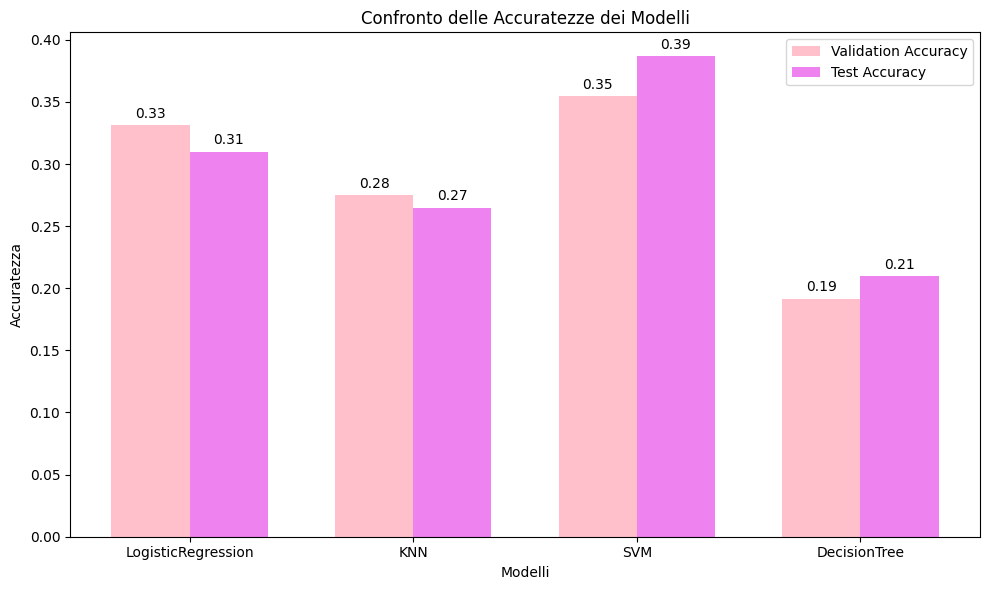

In [5]:
import matplotlib.pyplot as plt

model_names = list(results.keys())
val_accuracies = [results[model]['val_accuracy'] for model in model_names]
test_accuracies = [results[model]['test_accuracy'] for model in model_names]

x = np.arange(len(model_names))
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, val_accuracies, width, label='Validation Accuracy', color='pink')
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='violet')

ax.set_xlabel('Modelli')
ax.set_ylabel('Accuratezza')
ax.set_title('Confronto delle Accuratezze dei Modelli')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

In [6]:
print("\nRiepilogo:")
for name, res in results.items():
    print(f"{name}: Test Accuracy = {res['test_accuracy']:.4f}")

best_model_name = max(results, key=lambda x: results[x]['test_accuracy'])
print(f"\nMiglior modello: {best_model_name} con accuracy = {results[best_model_name]['test_accuracy']:.4f}")


Riepilogo:
LogisticRegression: Test Accuracy = 0.3100
KNN: Test Accuracy = 0.2650
SVM: Test Accuracy = 0.3867
DecisionTree: Test Accuracy = 0.2100

Miglior modello: SVM con accuracy = 0.3867
